# Introduction

Deep Learning neural networks represent a powerful paradigm in machine learning, based on the structure and function of the human brain. These ever evolving technologies have been utilised in so many other aspects, bring us grat convenience and benefits. Needless to say, machine learning and neural networks will be a mainstay technology in the future years to come. As such I would like to try my hand at building a neural network capable of classifying images. This project aims to build a neural network capable of diffrentiating between two kinds of images, either containing humans or horses.

## Data

The dataset I will be working with is the 'humans_or_horses' dataset from tensorflow. Tensorflow provides many kinds of datasets suitable for machine learning and neural network tasks and their datasets are curated and standardized, ensuring high-quality data and facilitating easy integration into the training pipeline. The dataset was created by Laurence Moroney and contains images of horses and humans. The images of horses comes in various species and poses, while the human images has included various races and poses as well (Moroney)[[1]](#ref-1). As such the dataset serves as a good foundation for developing an image classification model for this project. Since the main task is to differentiate between images of humans or horses, this is a binary classification problem.

In [ ]:
!pip install --upgrade tensorflow

In [2]:
#importing relavent libraries
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import F1Score, AUC

import itertools
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

import warnings
warnings.filterwarnings('ignore')

C:\Users\Bakab\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preparing data
The code blocks below are used for preparing the dataset for the classification. The dataset, labeled 'horses_or_humans', is loaded using TensorFlow Datasets (tfds). Following this, the images and their corresponding labels are extracted from the dataset. To enhance computational efficiency and reduce the complexity of the input data, two preprocessing steps are performed: dimensionality reduction and grayscale conversion.

Reducing dimensionality is important for various reasons. Firstly, it lessens the computational load brought on by handling high-dimensional data, which is frequently found in datasets containing images. Without significantly reducing image detail, computing resources can be saved by downsizing the photographs to a lower resolution of (32, 32, 3). Furthermore, lowering dimensionality can aid in preventing overfitting, a condition in which a model gains memorization of the training set instead of making generalizations.

The data format is further simplified using grayscale image conversion. Whereas RGB images have three color channels (red, green, and blue), grayscale images simply have intensity values. Grayscale conversion reduces the input space and concentrates the model's attention on the key characteristics and features needed for classification by removing color information. This lowers the likelihood of overfitting and increasing the model's capacity to discern important patterns from the images. 

In [3]:
#dataset name
DATASET = 'horses_or_humans'

#resize and grayscale
RESIZE = (32, 32, 3)
GRAY_SCALE = True

In [4]:
#loading dataset from tensorflow
df = tfds.load(DATASET, split='all', shuffle_files=True)

#initialize list for storing
images, labels = [], []
for entry in df.take(len(df)) :
    #extract image and labels
    image, label = entry['image'], entry['label']
    
    #convert to numpy array
    image, label = image.numpy(), label.numpy()
    
    #resizing images
    image = resize(image, RESIZE, anti_aliasing=True)
    
    #converting to grayscale
    if GRAY_SCALE :
        image = rgb2gray(image)
    
    #apend to the array
    images.append( image )
    labels.append( label )

In [5]:
#list of images to numpy array
X = np.array(images)

#binary output, 0 or 1
y = np.array(labels)

#show total images
print(len(X))

1283


To ensure that the right dataset from tensorflow is being used, the code below is utilised to generate 5 random images from the dataset. This gives us a glimpse of what the dataset looks like by providing us with some sample images from the dataset.

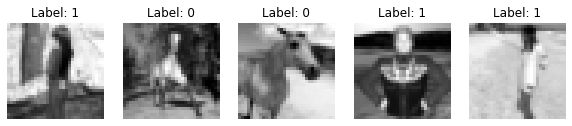

In [6]:
import random

#number of random images to display
num_images_to_show = 5

#get the total number of images in the dataset
total_images = X.shape[0]

#generate random samples of images
random_indices = random.sample(range(total_images), num_images_to_show)

#show the random images
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(X[idx], cmap='gray' if GRAY_SCALE else None)
    plt.title('Label: {}'.format(y[idx]))
    plt.axis('off')
plt.show()

In the code below, a portion of the dataset is put aside for testing and the dataset is split into train and test sets. The pixel values are also normalised to ensure that the model can effectively learn from the data by bringing consistency to the input features. Normalization helps in stabilising and speeding up the training process by making the optimisation algorithm converge faster. Additionally, it prevents any particular features from dominating others, which could lead to biased learning.
Label data types are converted to float to allow for continuous values that can be integrated into the loss calculation and optimisation procedures.

In [7]:
#10% of the dataset is set aside for testing purposes
test_size = 0.1

#splitting the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y,
                                                    random_state=SEED, shuffle=True)

#normalise pixel values to the range [0, 1]
X_train, X_test = X_train / 255.0, X_test / 255.0

#determine size of the validation set
validation_size = X_test.shape[0]

#split the training set into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=validation_size, stratify=y_train,
                                                  shuffle=True, random_state=SEED)

#converting label data types to float
y_train, y_val, y_test = y_train.astype(float), y_val.astype(float), y_test.astype(float)

## Developing a model better than the baseline

In this section a model better than the baseline will be made(baseline model). A baseline model serves as a crucial starting point in machine learning projects, as it provides a reference against which to measure the performance of more improved and sophisticated models. This first model will aid in understanding the complexity of the problem and gauging the effectiveness of more advanced techniques. By establishing a baseline, we can evaluate the significance of improvements achieved by subsequent models and methodologies. 

In [8]:
#count the number of samples for each label in the training set
train_label_counts = np.bincount(y_train.astype(int))

#count the number of samples for each label in the validation set
val_label_counts = np.bincount(y_val.astype(int))

#count the number of samples for each label in the test set
test_label_counts = np.bincount(y_test.astype(int))

#print the number of samples per label
print("Training set label counts:", train_label_counts)
print("Validation set label counts:", val_label_counts)
print("Test set label counts:", test_label_counts)

Training set label counts: [502 523]
Validation set label counts: [63 66]
Test set label counts: [63 66]


In [9]:
#naive calculation
naiveBaseLine = (len(y)-np.sum(y)) / len(y)

print("The naive baseline is: ",naiveBaseLine)

The naive baseline is:  0.48947778643803586


Looking at the labels we can see the dataset is mildly unbalanced. Following the naive baseline calculation, the model should perform better than 0.4894

For this project, the Adam optimizer was chosen as it is known for its effectiveness and adaptability in neural network training, especially for jobs involving big datasets and high-dimensional input fields, facilitating faster convergence and improved generalization. Binary crossentropy is specifically tailored for binary classification problems, providing a robust measure of the discrepancy between predicted and true class labels. As for the choice of evaluation metrics, accuracy, F1 score and AUC were chosen for this project. Accuracy is a common metric that gives a straightforward measure of the model's overall performance in predicting the classes of the images. However since the dataset is mildly imbalanced, accuracy alone might not be as accurate. Thus F1 score is included which combines precision and recall, to provide a balance between false positives and false negatives. AUC is also used to measure the model's ability to distinguish between classes. The validation loss over successive epochs is also monitored and this helps safeguard against excessive model complexity and ensures optimal generalization performance.

For the architecture of the model, a Flatten layer, followed by a Dense layer with a sigmoid activation function is employed. The flatten layer is used to transform input data into a 1D array to ensure compatibility with the Dense layer. The sigmoid function facilitates binary classification by squashing the values between 0 and 1, thus representing the likelihood of the input belonging to one of the two classes. This setup allows the model to learn and make predictions accurately within the binary classification framework.

In [10]:
inputDimension = (32, 32, 1)
outputDimension= 1

#define optimizer, loss function, and evaluation metrics
optimizer= 'adam'
lossFunction = 'binary_crossentropy'
metrics_ = [F1Score(name="f1_score", average='micro'),
            'accuracy',
           AUC(name="auc")]

#monitor loss and specify number of epochs
monitor_ = 'val_loss'
patience_= 5

#earlystopiing criteria
earlyStop = EarlyStopping(monitor=monitor_, restore_best_weights=True, patience=patience_, verbose=0)

#define model architecture
baselineModel = Sequential(name="baseline")

baselineModel.add(Flatten(input_shape=inputDimension, name="flatten"))
baselineModel.add(Dense(outputDimension, activation="sigmoid", name="output"))

#show summary of model
baselineModel.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 output (Dense)              (None, 1)                 1025      
                                                                 
Total params: 1025 (4.00 KB)
Trainable params: 1025 (4.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
batch_size = 64
EPOCHS = 200
learningRate = 0.01
baselineModel.compile(optimizer=Adam(learning_rate=learningRate),
                 loss=lossFunction, metrics=metrics_)

In [12]:
#show evaluation metrics scores
baselineScores = baselineModel.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(baselineScores[0], naiveBaseLine))
print('F1 Score (Validation): {:.2f}'.format(baselineScores[1]))
print('AUC (Validation): {:.2f}'.format(baselineScores[2]))

Accuracy (Validation): 0.68 (Naive Baseline=0.49)
F1 Score (Validation): 0.51
AUC (Validation): 0.55


From the scores shown above we can see that the baseline model is performing within expectations, as the scores are above the calculated naive baseline of 0.49.

### Graph plotting
The next part visualizes the training and validation performance metrics of a model, particularly focusing on loss and AUC (Area Under the ROC Curve) using graphs. The function takes a history object as input, which contains the training history of a model obtained after fitting it to training data. 

Within the function, for each specified metric (e.g., loss), the training and validation values are extracted from the history object. Then, a plot is drawn to display the trends of these metrics across epochs. The x-axis represents the number of epochs, while the y-axis corresponds to the values of the chosen metric. Blue dots denote the training metric values, while red dots represent the corresponding validation metric values. This provides valuable insights into the model's performance during training and potential issues can be identified using these plots.

A loss plot visualises the performance of the model during training and validation by plotting the loss function values over epochs. Theyhelp measure how well the model's predictions match the actual target values and show if there is overfitting or underfitting involved. For this image classification, they can be used toprovide insights into how effectively the model is learning to distinguish between different classes as it progresses through training.

An AUC plot visualises the performance of a binary classification model across different thresholds for classification. In the context of this project, the AUC plot can show how well the model distinguishes between the two classes across different threshold values. This is also useful for imbalanced datasets as AUC is not affected by class distribution.

In [13]:
baselineHistory = baselineModel.fit(X_train, y_train,
                                batch_size=batch_size, epochs=EPOCHS,
                                validation_data=(X_val, y_val),
                                callbacks=[earlyStop],
                                verbose=0)

In [14]:
#function to plot loss/auc
def plot_training_history(history, monitors=['loss']):
    for monitor in monitors:
        #extract the training and validation metrics from the history object
        train_metric = history.history[monitor]
        val_metric = history.history['val_' + monitor]
        
        #generate the x-axis (epochs)
        epochs = range(1, len(train_metric) + 1)
        
        #plot the training and validation metrics
        plt.figure(figsize=(12,8))
        plt.plot(epochs, train_metric, 'b.', label=monitor)
        plt.plot(epochs, val_metric, 'r.', label='Validation ' + monitor)
        
        #set plot limits and labels
        plt.xlim([1, len(train_metric)])
        plt.title('Training and Validation ' + monitor.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(monitor.capitalize())
        plt.legend()
        plt.grid()
        
        #show the plot
        plt.show()

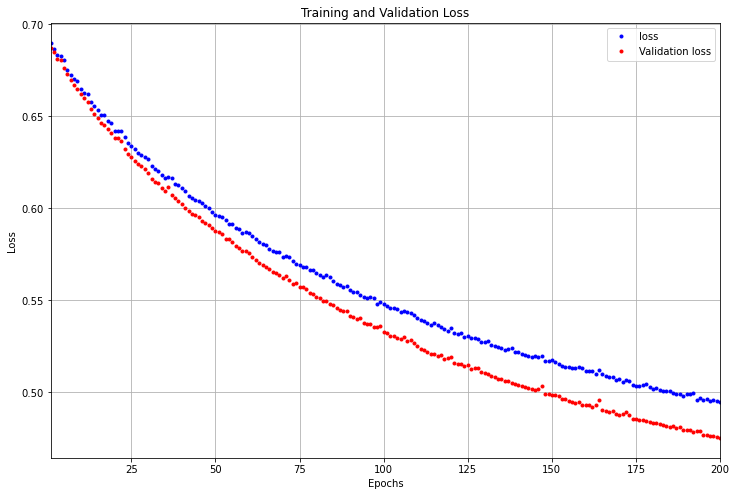

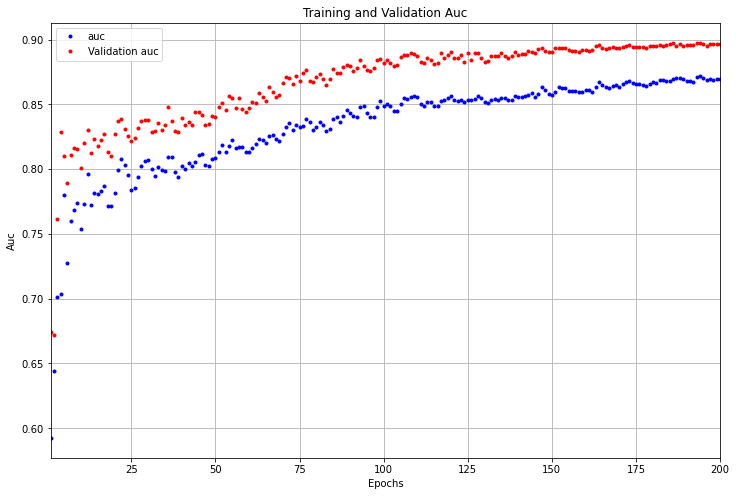

In [15]:
plot_training_history(baselineHistory, monitors=['loss', 'auc'])

### Baseline Plot findings

From the loss plot we can observe that both the training and validation loss start at a higher value but decrease steadily over time, indicating that the model is learning and improving its performance with each epoch. The training loss consistently decreases over time, showing that the model is learning and improving its performance on the training data. However, the validation loss plateaus around 50 epochs, suggesting that the model may not be improving on the validation data beyond this point. This could be a sign of overfitting, where the model is too closely fitting to the training data and not generalizing well to unseen data.

Similarly, the AUC plot shows an increase in both training and validation AUC initially, but they start to diverge after approximately 50 epochs. While the training AUC continues to rise, the validation AUC plateaus, further supporting the possibility of overfitting. The overfitting could be happening mainly due to lack of regualarisation used for the baseline model

## Overfitting model

In this next section, the model will be scaled up to an overfitting model. This is neccessary as it makes it possible to investigate the model's ability to adapt and learn. We may evaluate the model's capacity to identify complicated patterns in the data by making it more complex—either by adding additional layers, neurons, or training for a greater number of epochs. Furthermore, it aids in understanding the bias-variance tradeoff, guiding the selection of an optimal model that neither underfits nor overfits the data. Thus, scaling up is a vital step in the iterative process of model development, leading to a more robust and generalizable machine learning model. The code structure of the overfit model is similar to that of the previous baseline model except now it features an additional hidden layer with ReLU activation.

In [16]:
overfitModel = Sequential(name="overfit")

overfitModel.add(Flatten(input_shape=inputDimension, name="flatten"))
overfitModel.add(Dense(64, activation="relu", name="hidden"))
overfitModel.add(Dense(outputDimension, activation="sigmoid", name="output"))

overfitModel.summary()

Model: "overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 hidden (Dense)              (None, 64)                65600     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 65665 (256.50 KB)
Trainable params: 65665 (256.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
batch_size = 64
EPOCHS = 200
learningRate = 0.01
overfitModel.compile(optimizer=Adam(learning_rate=learningRate),
                 loss=lossFunction, metrics=metrics_)

In [18]:
overfitHistory = overfitModel.fit(X_train, y_train,
                              batch_size=batch_size, epochs=EPOCHS,
                              validation_data=(X_val, y_val),
                              callbacks=[],
                              verbose=0)

In [19]:
overfitScores = overfitModel.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(overfitScores[0], naiveBaseLine))
print('F1 Score (Validation): {:.2f}'.format(overfitScores[1]))
print('AUC (Validation): {:.2f}'.format(overfitScores[2]))

Accuracy (Validation): 0.68 (Naive Baseline=0.49)
F1 Score (Validation): 0.90
AUC (Validation): 0.96


### Comparing scores
Comparing the performance metrics of the baseline and scaled-up model, it’s clear that the scaled-up model significantly outperforms the baseline model in terms of F1 Score and AUC, while maintaining the same level of accuracy.

The F1 Score for the scaled-up model is 0.90, a substantial improvement from the baseline model’s score of 0.51. This indicates that the scaled-up model is much better at balancing precision and recall, making it more effective at identifying positive instances.

The AUC for the scaled-up model is 0.96, which is significantly higher than the baseline model’s AUC of 0.55. An AUC of 0.96 indicates that the scaled-up model has excellent discriminative power and is highly capable of distinguishing between positive and negative classes.

Interestingly, the Accuracy for both models is the same at 0.68, which is higher than the naive baseline of 0.49. This suggests that both models are better than a naive model that makes predictions based on the majority class.

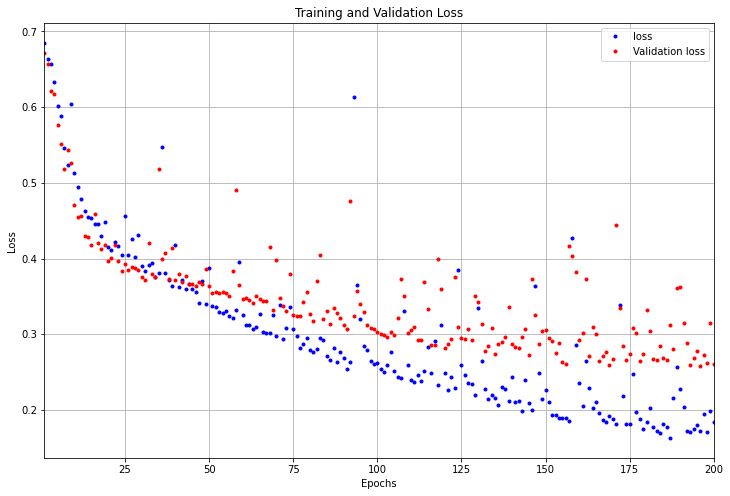

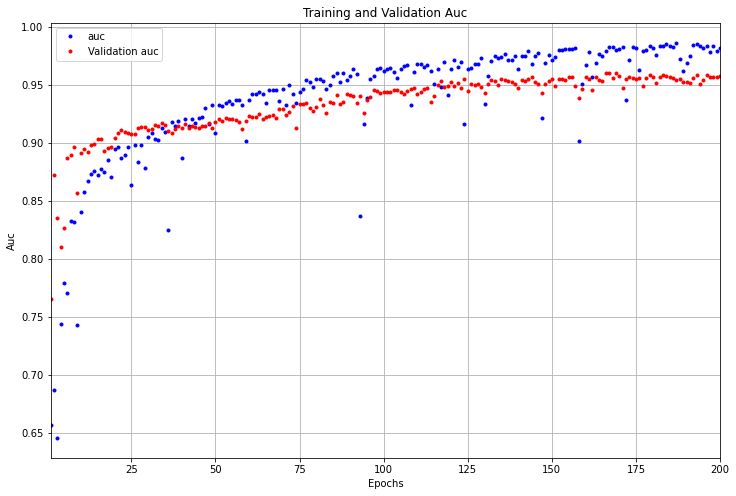

In [20]:
plot_training_history(overfitHistory, monitors=['loss', 'auc'])

### Scaled up model findings
By comparing this overfitted model to the first baseline model, which showed both training and validation loss decreasing and converging to a lower value, we can observe the effects of increasing the model’s complexity. While the baseline model generalized well with some overfitting present, the scaled-up model, due to its increased complexity, starts to overfit more after a certain number of epochs. 

In the loss plot, both training and validation losses decrease initially, which is a positive sign of learning. The training loss decreases steadily, indicating that the model is learning from the training data. However, the validation loss decreases at a slower rate and a gap appears between the training and validation loss after around 50 epochs. This is a clear sign of overfitting, which in this case is intentional due to the scaling up of the model.

Similarly, in the AUC plot, both training and validation AUC increase initially, indicating that the model’s ability to distinguish between classes is improving. But they start to diverge after around 25 epochs. The training AUC continues to rise while the validation AUC plateaus. This is another indication of the model’s increasing specialization to the training data and also a sign of overfitting. This comparison provides valuable insights into the bias-variance tradeoff and guides the selection of an optimal model.

## Hyperparameter tuning and regularisation

This next part will focus on hyperparameter tuning and regularisation. These two processes play an important role in machine learning for improving model performance, generalization, and robustness. Hyperparameter tuning involves selecting the optimal values for parameters that control the learning process, such as the learning rate, number of hidden layers, or activation functions. This helps fine-tune the model's architecture to better fit the data and improve performance metrics. Regularisation is used to prevent overfitting by reducing the impact of noisy features. The code below utilises a function to perform grid search cross-validation to find the best hyperparameters for a neural network model. k-fold cross-validation is used to assess the performance of several models with various combinations of hyperparameters. The results are are then printed out and shown. The model used is of a similar architecture to the previous models. However regularisation techniques such as dropout and early stopping to mitigate overfitting are incorporated. The dataframe is then sorted according to highest AUC values allowing quicker identification of the best-performing models.

In [25]:
#grid search function. Code modified from material from my educational institure [2]
def grid_search_crossVal(X, y, param_grid, cv, learning_rate, lossFunction, metrics_, epochs, earlyStop):
    #empty list to store results
    results = []

    #iterating over combinations of hyperparameters
    for params in ParameterGrid(param_grid):
        
        #lists to store scores and epochs for each fold
        scores = []
        epochs_list = []
        
        #cross-validation
        for train_index, val_index in StratifiedKFold(n_splits=cv).split(X, y):
            X_train_fold, X_val_fold = X[train_index], X[val_index]
            y_train_fold, y_val_fold = y[train_index], y[val_index]
            
            #create and compile the model with current hyperparameters
            model = Sequential()
            model.add(Flatten(input_shape=X.shape[1:], name="flatten"))
            for _ in range(params['hidden_layers']):
                model.add(Dense(params['neurons'], activation=params['activation']))
                model.add(Dropout(params['dropout']))
            model.add(Dense(1, activation="sigmoid", name="output"))
            model.compile(optimizer=Adam(learning_rate=learning_rate), loss=lossFunction, metrics=metrics_)
            
            #model trainng
            history = model.fit(X_train_fold, y_train_fold, batch_size=params['batch_size'], epochs=epochs, verbose=0)
            
            #model evaluation
            score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
            
            #append the score and the number of epochs to the respective lists
            scores.append(score)
            epochs_list.append(len(history.history['loss']))
        
        #compute mean score and the mean number of epochs across all folds
        mean_score = np.mean(scores, axis=0)
        mean_epochs = np.mean(epochs_list)
        
        #append the mean score, the mean number of epochs, and the hyperparameters to results list
        results.append((mean_score, mean_epochs, params))

    #sort the results by score (accuracy) in descending order
    results.sort(key=lambda x: x[0][1], reverse=True)

    #return the best score (accuracy, f1, auc), the corresponding number of epochs, and hyperparameters
    return results[0]

In [26]:
#hyperparameter search space
param_grid = {
    'hidden_layers': [1, 2],
    'neurons': [64],
    'activation': ['relu'],
    'dropout': [0.2],
    'batch_size': [128]
}

KFOLDS = 5
learning_rate = 0.001
epochs = 1000

scores, epochs, params = grid_search_crossVal(X_train, y_train, param_grid, KFOLDS, learning_rate, 
                                              lossFunction, metrics_, epochs, earlyStop)
print("Best Accuracy: %f, Best F1: %f, Best AUC: %f, Epochs: %f using %s" % (scores[1], scores[2], scores[3], epochs, params))

Best Accuracy: 0.752280, Best F1: 0.942439, Best AUC: 0.972540, Epochs: 1000.000000 using {'activation': 'relu', 'batch_size': 128, 'dropout': 0.2, 'hidden_layers': 2, 'neurons': 64}


### Optimized model
After the grid search has been completed and the hyperparamters are obtained, the next section of code will be used for building and training a more optimized model based on the hyperparameters. The same learning rate will be used similar to that of the previous models. This model is amde up of a flatten layer used to reshape the data followed by a dense hidden layer with 64 neurons activated by the ReLU function. A dropout layer with a dropout rate of 0.2 is included as well based on the hyperparameters from grid search. Lastly, the output layer consists of a single neuron with a sigmoid activation function, since this is a binary classification problem. Similarly a plot for the loss functions and AUC are plotted onto a graph as well. The model is then compiled using the Adam optimizer and trained using the training dataset.

In [27]:
learning_rate = 0.01

#define the model
optimizedModel = Sequential(name='Deep_Network')

#add a Flatten layer to reshape the input
optimizedModel.add(Flatten(input_shape=inputDimension))

#add the hidden layer
optimizedModel.add(Dense(64, activation='relu'))

#add dropout base on grid search
optimizedModel.add(Dropout(0.2))

#add the output layer
optimizedModel.add(Dense(outputDimension, activation='sigmoid'))

#compile the model
optimizedModel.compile(optimizer=Adam(learning_rate=learning_rate), 
                       loss=lossFunction, 
                       metrics=metrics_)

#print summary
optimizedModel.summary()

Model: "Deep_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 64)                65600     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 65665 (256.50 KB)
Trainable params: 65665 (256.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
batch_size = 64
EPOCHS = 200
# Train the model
optimizedModelHistory = optimizedModel.fit(X_train, y_train,
                                           batch_size=batch_size, epochs=EPOCHS,
                                           validation_data=(X_val, y_val),
                                           callbacks=[],
                                           verbose=0)

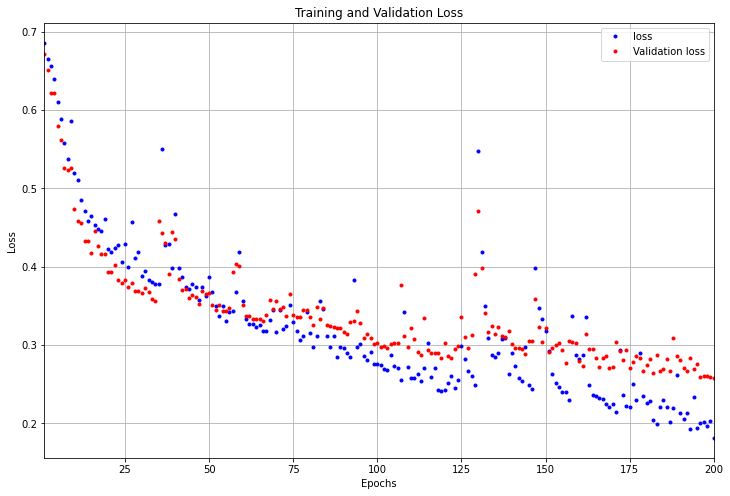

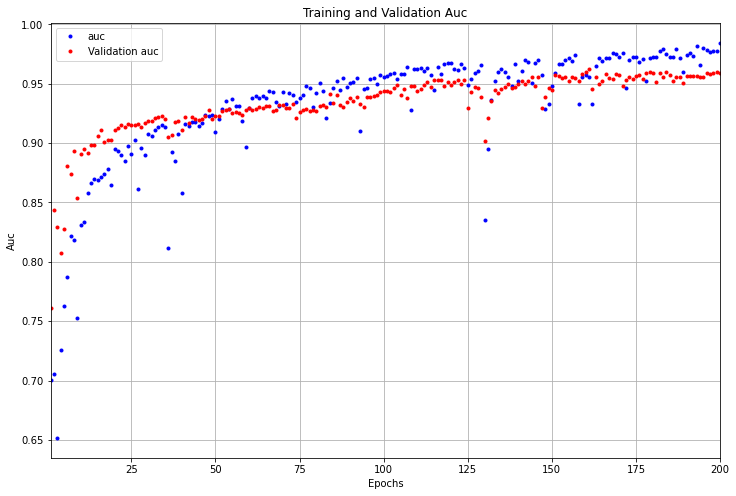

In [29]:
plot_training_history(optimizedModelHistory, monitors=['loss', 'auc'])

### Optimized model graph findings
Based on the plots of the optimized model shown above. The model has demonstrated strong performance in classifying the images of horses and humans. The training loss steadily decreases across epochs, an indication that the model is learning effectovely from the training data. However, there are fluctuations in the validation loss which could suggest a level of overfitting or noise in the data.

Based on the AUC plot, the training and validation AUC can be seen increasing over time. This increse suggests that the model's classification capabilities are improving. The validation AUC also flutuates around 0.95 suggesting a good true positive rate and low false positive rate.

Compared to the previous plots, the optimized model appears to have a more stable performance with less overfitting. The fluctuations in the validation loss are smaller and the gap between the training and validation AUC is less pronounced. Although there may still be some fluctuations present, the hyperparameter tuning and k-fold validation have helped to improve the model’s generalization ability and performance on unseen data.

In [30]:
optimizedScores = optimizedModel.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(optimizedScores[0], naiveBaseLine))
print('F1 Score (Validation): {:.2f}'.format(optimizedScores[1]))
print('AUC (Validation): {:.2f}'.format(optimizedScores[2]))

Accuracy (Validation): 0.68 (Naive Baseline=0.49)
F1 Score (Validation): 0.89
AUC (Validation): 0.96


From the scores of the optimized model we can see that it fared much better than the previous two models with an increase in F1 score and AUC score. The high F1 score of 0.89 indicates the model's good balance between precision and recall, while the high AUC score of 0.96 suggests a very strong true positive rate and low false positive rate. Based on the validation data, it would seem that the model demonstrates a strong performance in differentiating between images of horses and humans. Following that the next part of code will use the test dataset to evaluate the optimized model.

In [31]:
#returns the predicted probabilities
predicted = optimizedModel.predict(X_test, verbose=0)

#threshold to determine positive or negative
threshold = 0.5

#metrics calculation
accuracy = accuracy_score(y_test, (predicted > threshold).astype('int32'))
f1 = f1_score(y_test, (predicted > threshold).astype('int32'))
auc = roc_auc_score(y_test, predicted)

print('Accuracy (Test): {:.2f}'.format(accuracy))
print('F1 Score (Test): {:.2f}'.format(f1))
print('AUC (Test): {:.2f}'.format(auc))

Accuracy (Test): 0.94
F1 Score (Test): 0.94
AUC (Test): 0.97


From the evaluation metrics of the test set, we can observe that the optimized model performed very well. The accuracy is rather high at 0.94 which is the same as the F1 score. This suggests that the model is generalizing well to unseen data and making correct predictions more often and a good balance is maintained between precision and recall. The AUC score is similar to the score based on validation data and only slightly outperforms the validation set. Overall the score indicates that the optimized model is rather well-trained.

The next line of code is used to generate a confusion matrix using scikilearn. A confusion matrix is used in classification tasks to evaluate how well the model performs by providing a summary of how the model's predictions relate to the actual ground truth labels for each class.

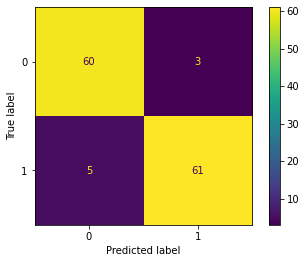

In [32]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test, (predicted > 0.5).astype('int32')) )
_ = disp.plot()

From the confusion matrix above we can observe that the model correctly identified 61 images of humans (True Positives) and 60 images of horses (True Negatives). This indicates that the model is quite effective at recognizing both classes. There were 3 instances where the model incorrectly predicted a horse image as a human (False Positives). This suggests that there might be certain features in these horse images that the model might associate with that of humans, leading to these misclassifications.
There were 5 instances where the model incorrectly predicted a human image as a horse (False Negatives). This could mean that these particular human images may lack certain features that the model associates with humans, or they may have features that the model associates with horses.
The high number of true positives and negatives compared to the number of false positives and negatives show that the optimized model is performing well and has a good ability to classify between the two classes. The presence of false positives and negatives also suggests that there is further room for the model to improve.

## Improvements
From the plots for the optimized model, we can see that there is some overfitting and fluctuations present. The presence of false positives and negatives also suggest that there is room for improvement. Further improvements can be made to the model such as by gathering more data or images in this case. L1 and L2 regularisation can also be used to potentially reduce the overfitting seen in the plots and encourage the model to find simpler solutions that generalize better to unseen data. Alternatively I could have also made use of bootstrap aggregating to create each subset by randomly sampling the original dataset with replacement and having the final prediction made by majority voting. This method can potentially help decrease the variance and avoid overfitting.

## Conclusion
This project's main goal was to create a reliable classification model that could tell apart images of horses from humans. The process started with the development of a baseline model that would be used as a point of reference. Then, a scaled-up model with greater complexity was put into place which led to overfitting. This was then addressed by making use of hyperparameter tuning and regularisation using gridsearch and the results were used to make a more optimized model in the form of a deep network. The final optimized model exceeded the performance of the previous iterations showcasing how hyperparameter tuning was able to enhance the performance of a model. Even though there is still room for improvement, through this process, the project accomplished its goal of constructing a reliable and accurate classifier for distinguishing between images of horses and humans.

### References
<a id="ref-1">[1]https://laurencemoroney.com/datasets.html</a> <br>
[2]Material from educational institute